背景：传统防窃漏方法报警时间发生前后客户计量点有关电流、电压、负荷数据等情况，构建基于指标加权用电异常分析模型，发现窃电、违章用电情况
      缺点：终端误报或漏报过多，无法快速、精确定位窃漏用户；指标权重确定需要专家知识，具有主观性
     
改进：提取窃漏用户关键特征，构建窃漏用户的识别模型
      
      所需数据：固定数据：用户名称、编号、地址、用电类别、违约窃电处理记录、计量方法及依据；实时数据：时间点、功率、电流、电压
      采样注意事项：包含全部窃漏电用户和部分正常用户
      输出结果：某一时间段每天用户是否窃电的标志

数据探索
    
    分布分析：不同类别的用户窃电情况--->非居民用户几乎没有窃电----->分析过程中删去这类用户
    周期性分析：随机抽取一个窃电用户和一个正常用户，观察其在不同时间的用电量情况--->均呈现周期性：节假日用电量少；正常用户在其他时间用电量几乎相同，而窃电用户用电量则出现持续下降情况

数据预处理

    1）删除“非居民”用户；删除节假日
    2）缺失数据插补：拉格朗日法（根据缺失值前后数据加权得到）
    3）数据变换：建立评价体系（从用电量趋势、线损增长率、终端警告三个角度）
    
    构造描述用电量趋势的指标
    思路：附近区间的斜率
    1、直接计算某两邻近点的斜率作为用电趋势的缺点：有偶然性
    2、改进：综合所有邻近点的数据+协方差思想（如果两个变量朝着相同的方向变化则正相关）----引申：如果用电量和时间变化的“协方差”为负则用电量有下降趋势；
    3、上述方法缺点：不同时间的结果不具有可比性（随时间的增大【第L天】，结果随之增加）
    4、改进：剔除时间变化影响：除以时间的方差
    5、最后返回结果：后一天的用电量趋势小于于前一天，则为1（表示下降），否则为0
    
    构造线损率指标
    思路：线路供电量s与总的用电量f的差值与线路供电量s的比值（当发生窃电时，上述指标增大）
    缺点：用户每天的用电量有波动，仅用一天的值结果会有偏差
    改进：考虑前后几天的平均值(后5天均值与前5天均值的增长比较），并设置增幅阈值（增长率超过1%，则发生窃电）

# 拉格朗日插补法

In [2]:
import pandas as pd

In [6]:
?pd.read_excel

In [24]:
process_miss=pd.read_excel('demo/data/missing_data.xls',header=None)
process_miss.columns=['user1','user2','user3']
process_miss.head()

,user1,user2,user3
0,235.8333,324.0343,478.3231
1,236.2708,325.6379,515.4564
2,238.0521,328.0897,517.0909
3,235.9063,NaN,514.8900
4,236.7604,268.8324,NaN


In [19]:
from scipy.interpolate import lagrange 
#定义列向量差值函数
def polyinterp_column(s,n,k=5):
    y=s[list(range(n-k,n))+list(range(n+1,n+1+k))]
    y=y[y.notnull()]#剔除前后5项中的空值
    return lagrange(y.index,list(y))(n)

缺失值相关的几个函数：
1、notnull()
2、isnull()
前两个都是针对向量的函数，返回布尔向量，通常用在筛选行的情景中，比如筛选非空行：data=data[data['col1'].notnull()]选出col1一列中非空的数据
3、fillna()
4、dropna()
后两个是针对df的函数

In [17]:
process_miss['user1'].isnull()

0     False
1     False
2     False
3     False
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12     True
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
Name: user1, dtype: bool

In [22]:
#逐列逐行寻找空值
for i in process_miss.columns:
    for j in range(len(process_miss)):
        if(process_miss[i].isnull())[j]:
            print('(%s,%s)'%(i,j))
            process_miss[i][j]=polyinterp_column(process_miss[i],j)
process_miss.head()

(user1,5)
(user1,12)
(user2,3)
(user2,10)
(user2,19)
(user2,20)
(user3,4)
(user3,7)


E:\Software\anaconda\lib\site-packages\pandas\core\series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


(user3,10)
(user3,16)


,user1,user2,user3
0,235.8333,324.034300,478.323100
1,236.2708,325.637900,515.456400
2,238.0521,328.089700,517.090900
3,235.9063,203.462116,514.890000
4,236.7604,268.832400,493.352591


# 分类预测（LM神经网络和CART决策树）

In [47]:
data=pd.read_excel('demo/data/model.xls')
data.head()

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
0,4,1,1,1
1,4,0,4,1
2,2,1,1,1
3,9,0,0,0
4,3,1,0,0


In [48]:
from random import shuffle
#划分训练集和验证集
data=data.as_matrix()
shuffle(data)#随机打乱数据

p=0.8
train=data[:int(len(data)*p),:]#矩阵不能通过iloc索引数据
test=data[int(len(data)*p):,:]

In [29]:
import matplotlib.pyplot as plt
#定义混淆矩阵
def cm_plot(y, yp):
    from sklearn.metrics import confusion_matrix#导入混淆矩阵函数
    cm = confusion_matrix(y, yp) 
    
    plt.matshow(cm, cmap=plt.cm.Greens)#配色风格使用cm.Greens
    plt.colorbar()#颜色标签
    
    for x in range(len(cm)):#数据标签
        for y in range(len(cm)):
            plt.annotate(cm[x,y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
  
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
    return plt

In [32]:
#定义ROC曲线
from sklearn.metrics import roc_curve
 
def roc_curve_plt(predict,model_type):
    fpr,tpr,thresholds=roc_curve(test[:,3],predict,pos_label=1)#计算真正率和假正率
    plt.plot(fpr,tpr,linewidth=2,label='Roc of '+model_type)#对两个指标划线
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim(0,1.05)
    plt.xlim(0,1.05)
    plt.legend(loc=4)
    return plt

In [98]:
#================LM神经网络===========

from keras.models import Sequential
from keras.layers.core import Dense,Activation

model = Sequential() 
model.add(Dense(10,input_dim=3,activation='relu'))
model.add(Dense(1))
model.compile(loss='binary_crossentropy',optimizer='adam')

#model.fit(train[:,:3],train[:,3],nb_epoch=1000,batch_size=1)#训练一万次

In [62]:
#训练集预测
predict=model.predict_classes(train[:,:3]).reshape(len(train))
predict[0:10]

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

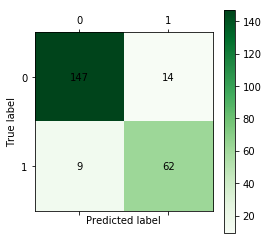

In [63]:
#训练集评价
cm_plot(train[:,3],predict).show()#模型准确率为90%，正常用户被误判的有6%、窃电用户被漏判的有3.9%

In [71]:
3/59

0.05084745762711865

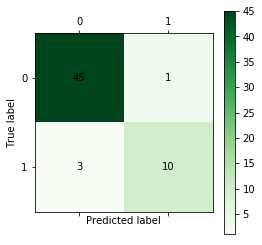

In [67]:
#测试集评价
cm_plot(test[:,3],model.predict_classes(test[:,:3]).reshape(len(test))).show()#模型准确率为93%，正常用户被误判的有1.7%、窃电用户被漏判的有5%

<module 'matplotlib.pyplot' from 'E:\\Software\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

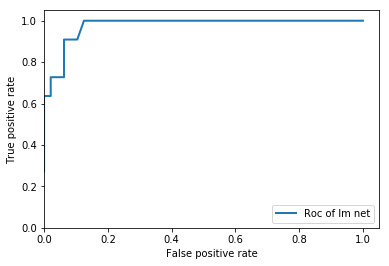

In [73]:
predict_lm=model.predict(test[:,:3]).reshape(len(test))#返回分类前的概率
roc_curve_plt(predict_lm,'lm net')

In [43]:
model.predict_classes(test[:,:3]).reshape(len(test))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<function matplotlib.pyplot.show>

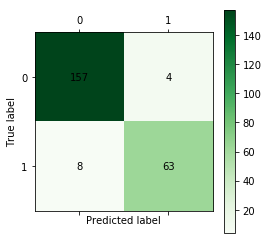

In [8]:
#==================CART决策树模型===============
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier()
clf.fit(train[:,:3],train[:,3])
#训练集误差
cm_plot(train[:,3],clf.predict(train[:,:3])).show()#模型准确率为94.8% 正常用户被误判的有1.7% 窃电用户被漏判的有3.4%

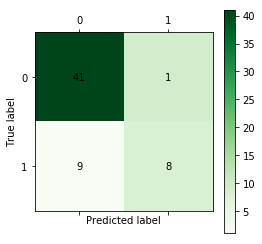

In [12]:
#验证集误差
cm_plot(test[:,3],clf.predict(test[:,:3])).show()#模型准确率为69.5% 正常用户被误判的有1.7% 窃电用户被漏判的有15.2%

In [33]:
predict_clf=clf.predict_proba(test[:,:3])[:,1]#计算模型分类之前的概率，更好地排序，从而逐个计算fpr和tpr，方便绘制ROC曲线

In [26]:
?roc_curve

<module 'matplotlib.pyplot' from 'E:\\Software\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

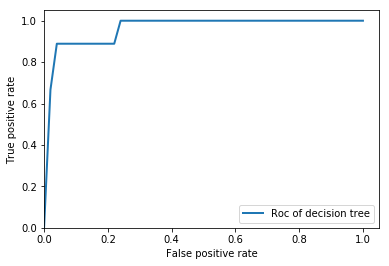

In [34]:
roc_curve_plt(predict_clf,'decision tree')

In [126]:
#具体指数
from sklearn.metrics import roc_auc_score
#决策树
roc_auc_score(test[:,3],clf.predict(test[:,:3]))

0.9791666666666667

In [81]:
#神经网络
roc_auc_score(test[:,3],model.predict(test[:,:3]))

0.9763257575757576

# 交叉验证

In [82]:
#由于随机打乱数据选取训练集和验证集每次得到的结果不同,所以采用交叉验证
X=data[:,:3]
y=data[:,3]
from sklearn import cross_validation

E:\Software\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [84]:
import numpy as np
np.random.seed(42)
#ShuffleSplit一种cv方式，除此之外，还包括Kfold、Stratified k-fold等
shuffle_validator=cross_validation.ShuffleSplit(len(X),n_iter=10,test_size=0.2,random_state=0)

In [88]:
#决策树交叉验证效果
cross_tree=cross_validation.cross_val_score(clf,X,y,cv=shuffle_validator)#cv即上述交叉验证的定义，clf是分类器
print("Accuracy %0.4f (+/-%0.2f)" % (cross_tree.mean(),cross_tree.std()))

Accuracy 0.9339 (+/-0.03)


In [92]:
#随机森林交叉验证效果
from sklearn.ensemble import RandomForestClassifier
np.random.seed(42)
rcf=RandomForestClassifier(n_estimators=50)#定义树的个数
cross_tree_rfc=cross_validation.cross_val_score(rcf,X,y,cv=shuffle_validator)#cv即上述交叉验证的定义，clf是分类机器学习模型
print("Accuracy %0.4f (+/-%0.2f)" % (cross_tree_rfc.mean(),cross_tree_rfc.std()))

Accuracy 0.9458 (+/-0.02)


In [94]:
#boosting 交叉验证效果
from sklearn.ensemble import GradientBoostingClassifier
np.random.seed(42)
bcf=GradientBoostingClassifier(n_estimators=50)#定义boosting循环个数
cross_tree_bcf=cross_validation.cross_val_score(bcf,X,y,cv=shuffle_validator)#cv即上述交叉验证的定义，clf是分类机器学习模型
print("Accuracy %0.4f (+/-%0.2f)" % (cross_tree_bcf.mean(),cross_tree_bcf.std()))

Accuracy 0.9271 (+/-0.03)


In [133]:
#定义计算准确率函数（PS：keras神经网络没有直接求准确率的函数，evaluate只能求损失率）
def accuracy(test,pred):
    df=pd.DataFrame()
    df['test']=test
    df['pred']=pred
    return sum(df['test']==df['pred'])/len(df)

In [134]:
mean=[]
#神经网络交叉验证效果：无法直接通过cross_val_score函数获取评价指标，采取循环办法
for train_index, test_index in shuffle_validator:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train,nb_epoch=1000,batch_size=100)
    pred=model.predict_classes(X_test)
    score=accuracy(y_test,pred)
    print("Accuracy %0.4f" % score)
    mean.append(score)
    

Epoch 1/1000
232/232 [==============================] - 0s 323us/step - loss: 0.3369
Epoch 2/1000
232/232 [==============================] - 0s 142us/step - loss: 0.3370
Epoch 3/1000
232/232 [==============================] - 0s 263us/step - loss: 0.3358
Epoch 4/1000
100/232 [===========>..................] - ETA: 0s - loss: 0.2890

E:\Software\anaconda\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


232/232 [==============================] - 0s 142us/step - loss: 0.3360
Epoch 5/1000
232/232 [==============================] - 0s 267us/step - loss: 0.3379
Epoch 6/1000
232/232 [==============================] - 0s 142us/step - loss: 0.3389
Epoch 7/1000
232/232 [==============================] - 0s 95us/step - loss: 0.3370
Epoch 8/1000
232/232 [==============================] - 0s 168us/step - loss: 0.3352
Epoch 9/1000
232/232 [==============================] - 0s 108us/step - loss: 0.3356
Epoch 10/1000
232/232 [==============================] - 0s 99us/step - loss: 0.3361
Epoch 11/1000
232/232 [==============================] - 0s 103us/step - loss: 0.3363
Epoch 12/1000
232/232 [==============================] - 0s 95us/step - loss: 0.3355
Epoch 13/1000
232/232 [==============================] - 0s 86us/step - loss: 0.3363
Epoch 14/1000
232/232 [==============================] - 0s 147us/step - loss: 0.3355
Epoch 15/1000
232/232 [==============================] - 0s 99us/step - loss:

232/232 [==============================] - 0s 60us/step - loss: 0.3351
Epoch 101/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3360
Epoch 102/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3369
Epoch 103/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3365
Epoch 104/1000
232/232 [==============================] - 0s 82us/step - loss: 0.3353
Epoch 105/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3352
Epoch 106/1000
232/232 [==============================] - 0s 73us/step - loss: 0.3356
Epoch 107/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3356
Epoch 108/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3350
Epoch 109/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3363
Epoch 110/1000
232/232 [==============================] - 0s 99us/step - loss: 0.3355
Epoch 111/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3363
Epoch 196/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3372
Epoch 197/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3360
Epoch 198/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3348
Epoch 199/1000
232/232 [==============================] - 0s 91us/step - loss: 0.3348
Epoch 200/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3372
Epoch 201/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3364
Epoch 202/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3339
Epoch 203/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3369
Epoch 204/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3371
Epoch 205/1000
232/232 [==============================] - 0s 73us/step - loss: 0.3346
Epoch 206/1000
232/232 [==============================] - 0s 60us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3362
Epoch 291/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3356
Epoch 292/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3351
Epoch 293/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3352
Epoch 294/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3354
Epoch 295/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3358
Epoch 296/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3348
Epoch 297/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3349
Epoch 298/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3349
Epoch 299/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3350
Epoch 300/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3348
Epoch 301/1000
232/232 [==============================] - 0s 65us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 386/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 387/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3349
Epoch 388/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3346
Epoch 389/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3358
Epoch 390/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3358
Epoch 391/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 392/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 393/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 394/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3345
Epoch 395/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3357
Epoch 396/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3355
Epoch 481/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3362
Epoch 482/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3359
Epoch 483/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3353
Epoch 484/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3364
Epoch 485/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3359
Epoch 486/1000
232/232 [==============================] - 0s 78us/step - loss: 0.3354
Epoch 487/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3342
Epoch 488/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3361
Epoch 489/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3385
Epoch 490/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3350
Epoch 491/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3371
Epoch 576/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3395
Epoch 577/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3395
Epoch 578/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3369
Epoch 579/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3346
Epoch 580/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3360
Epoch 581/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3366
Epoch 582/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3357
Epoch 583/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3357
Epoch 584/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3347
Epoch 585/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3351
Epoch 586/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 52us/step - loss: 0.3356
Epoch 670/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3346
Epoch 671/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3346
Epoch 672/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3369
Epoch 673/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3363
Epoch 674/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3349
Epoch 675/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3350
Epoch 676/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 677/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3356
Epoch 678/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3365
Epoch 679/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3371
Epoch 680/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3383
Epoch 765/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3371
Epoch 766/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3353
Epoch 767/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3338
Epoch 768/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3345
Epoch 769/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3369
Epoch 770/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3347
Epoch 771/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3345
Epoch 772/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3379
Epoch 773/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3383
Epoch 774/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3372
Epoch 775/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3363
Epoch 860/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3369
Epoch 861/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3378
Epoch 862/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3349
Epoch 863/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 864/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3345
Epoch 865/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3347
Epoch 866/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3349
Epoch 867/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3346
Epoch 868/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3344
Epoch 869/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3358
Epoch 870/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 69us/step - loss: 0.3364
Epoch 955/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3374
Epoch 956/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3355
Epoch 957/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 958/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3357
Epoch 959/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3356
Epoch 960/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3357
Epoch 961/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3349
Epoch 962/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3351
Epoch 963/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3350
Epoch 964/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3350
Epoch 965/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3281
Epoch 50/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3278
Epoch 51/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3280
Epoch 52/1000
232/232 [==============================] - 0s 69us/step - loss: 0.3281
Epoch 53/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3281
Epoch 54/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3284
Epoch 55/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3277
Epoch 56/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3276
Epoch 57/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3278
Epoch 58/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3278
Epoch 59/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3282
Epoch 60/1000
232/232 [==============================] - 0s 47us/step - loss: 0

232/232 [==============================] - 0s 52us/step - loss: 0.3300
Epoch 146/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3316
Epoch 147/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3285
Epoch 148/1000
232/232 [==============================] - 0s 69us/step - loss: 0.3271
Epoch 149/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3268
Epoch 150/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3289
Epoch 151/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3301
Epoch 152/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3289
Epoch 153/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3281
Epoch 154/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3277
Epoch 155/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3278
Epoch 156/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3275
Epoch 241/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3275
Epoch 242/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3273
Epoch 243/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3278
Epoch 244/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3277
Epoch 245/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3272
Epoch 246/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3277
Epoch 247/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3276
Epoch 248/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3281
Epoch 249/1000
232/232 [==============================] - 0s 69us/step - loss: 0.3283
Epoch 250/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3284
Epoch 251/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3278
Epoch 336/1000
232/232 [==============================] - 0s 26us/step - loss: 0.3274
Epoch 337/1000
232/232 [==============================] - 0s 26us/step - loss: 0.3292
Epoch 338/1000
232/232 [==============================] - 0s 26us/step - loss: 0.3299
Epoch 339/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3294
Epoch 340/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3277
Epoch 341/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3274
Epoch 342/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3277
Epoch 343/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3283
Epoch 344/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3275
Epoch 345/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3275
Epoch 346/1000
232/232 [==============================] - 0s 30us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3273
Epoch 431/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3276
Epoch 432/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3277
Epoch 433/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3280
Epoch 434/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3277
Epoch 435/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3274
Epoch 436/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3276
Epoch 437/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3284
Epoch 438/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3284
Epoch 439/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3283
Epoch 440/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3271
Epoch 441/1000
232/232 [==============================] - 0s 56us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3290
Epoch 526/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3282
Epoch 527/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3278
Epoch 528/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3296
Epoch 529/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3280
Epoch 530/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3274
Epoch 531/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3278
Epoch 532/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3278
Epoch 533/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3273
Epoch 534/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3268
Epoch 535/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3283
Epoch 536/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3273
Epoch 621/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3277
Epoch 622/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3307
Epoch 623/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3314
Epoch 624/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3298
Epoch 625/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3272
Epoch 626/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3278
Epoch 627/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3291
Epoch 628/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3293
Epoch 629/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3267
Epoch 630/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3275
Epoch 631/1000
232/232 [==============================] - 0s 34us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3271
Epoch 716/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3297
Epoch 717/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3321
Epoch 718/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3301
Epoch 719/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3278
Epoch 720/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3286
Epoch 721/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3280
Epoch 722/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3270
Epoch 723/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3298
Epoch 724/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3292
Epoch 725/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3274
Epoch 726/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 56us/step - loss: 0.3298
Epoch 811/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3278
Epoch 812/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3300
Epoch 813/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3296
Epoch 814/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3296
Epoch 815/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3284
Epoch 816/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3296
Epoch 817/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3280
Epoch 818/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3274
Epoch 819/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3284
Epoch 820/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3278
Epoch 821/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3272
Epoch 906/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3273
Epoch 907/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3299
Epoch 908/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3289
Epoch 909/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3277
Epoch 910/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3281
Epoch 911/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3282
Epoch 912/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3277
Epoch 913/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3283
Epoch 914/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3288
Epoch 915/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3274
Epoch 916/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3294
Accuracy 0.9492
Epoch 1/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3198
Epoch 2/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3194
Epoch 3/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3194
Epoch 4/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3194
Epoch 5/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3192
Epoch 6/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3193
Epoch 7/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3196
Epoch 8/1000
232/232 [==============================] - 0s 69us/step - loss: 0.3187
Epoch 9/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3204
Epoch 10/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3207
Epoch 11/1000
232/232 [==============================] - 0s 43us/step - 

232/232 [==============================] - 0s 43us/step - loss: 0.3182
Epoch 97/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3188
Epoch 98/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3175
Epoch 99/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3177
Epoch 100/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3187
Epoch 101/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3191
Epoch 102/1000
232/232 [==============================] - 0s 82us/step - loss: 0.3195
Epoch 103/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3185
Epoch 104/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3181
Epoch 105/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3182
Epoch 106/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3182
Epoch 107/1000
232/232 [==============================] - 0s 60us/step -

232/232 [==============================] - 0s 39us/step - loss: 0.3176
Epoch 192/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3177
Epoch 193/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3180
Epoch 194/1000
232/232 [==============================] - ETA: 0s - loss: 0.598 - 0s 34us/step - loss: 0.3178
Epoch 195/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3181
Epoch 196/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3187
Epoch 197/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3187
Epoch 198/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3174
Epoch 199/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3168
Epoch 200/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3187
Epoch 201/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3204
Epoch 202/1000
232/232 [=====================

232/232 [==============================] - 0s 43us/step - loss: 0.3187
Epoch 286/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3175
Epoch 287/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3175
Epoch 288/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3175
Epoch 289/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3174
Epoch 290/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3179
Epoch 291/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3176
Epoch 292/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3172
Epoch 293/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3175
Epoch 294/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3181
Epoch 295/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3172
Epoch 296/1000
232/232 [==============================] - 0s 60us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3189
Epoch 381/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3177
Epoch 382/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3172
Epoch 383/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3176
Epoch 384/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3172
Epoch 385/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3172
Epoch 386/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3171
Epoch 387/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3168
Epoch 388/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3178
Epoch 389/1000
232/232 [==============================] - 0s 69us/step - loss: 0.3177
Epoch 390/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3176
Epoch 391/1000
232/232 [==============================] - 0s 60us/ste

232/232 [==============================] - 0s 52us/step - loss: 0.3179
Epoch 476/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3185
Epoch 477/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3176
Epoch 478/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3165
Epoch 479/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3176
Epoch 480/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3187
Epoch 481/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3198
Epoch 482/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3190
Epoch 483/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3185
Epoch 484/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3175
Epoch 485/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3201
Epoch 486/1000
232/232 [==============================] - 0s 60us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3176
Epoch 571/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3179
Epoch 572/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3177
Epoch 573/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3178
Epoch 574/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3173
Epoch 575/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3169
Epoch 576/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3179
Epoch 577/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3185
Epoch 578/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3191
Epoch 579/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3176
Epoch 580/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3174
Epoch 581/1000
232/232 [==============================] - 0s 65us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3174
Epoch 666/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3180
Epoch 667/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3170
Epoch 668/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3169
Epoch 669/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3175
Epoch 670/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3174
Epoch 671/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3168
Epoch 672/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3175
Epoch 673/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3179
Epoch 674/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3164
Epoch 675/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3186
Epoch 676/1000
232/232 [==============================] - 0s 65us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3168
Epoch 761/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3170
Epoch 762/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3168
Epoch 763/1000
232/232 [==============================] - 0s 69us/step - loss: 0.3171
Epoch 764/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3170
Epoch 765/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3177
Epoch 766/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3179
Epoch 767/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3177
Epoch 768/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3178
Epoch 769/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3170
Epoch 770/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3167
Epoch 771/1000
232/232 [==============================] - 0s 56us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3169
Epoch 856/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3166
Epoch 857/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3168
Epoch 858/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3188
Epoch 859/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3163
Epoch 860/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3158
Epoch 861/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3192
Epoch 862/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3196
Epoch 863/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3178
Epoch 864/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3164
Epoch 865/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3177
Epoch 866/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3183
Epoch 951/1000
232/232 [==============================] - 0s 69us/step - loss: 0.3178
Epoch 952/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3167
Epoch 953/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3168
Epoch 954/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3170
Epoch 955/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3174
Epoch 956/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3173
Epoch 957/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3169
Epoch 958/1000
232/232 [==============================] - 0s 73us/step - loss: 0.3191
Epoch 959/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3156
Epoch 960/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3180
Epoch 961/1000
232/232 [==============================] - 0s 73us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3242
Epoch 46/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3255
Epoch 47/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3250
Epoch 48/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3239
Epoch 49/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3227
Epoch 50/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3222
Epoch 51/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3226
Epoch 52/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3222
Epoch 53/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3224
Epoch 54/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3222
Epoch 55/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3220
Epoch 56/1000
232/232 [==============================] - 0s 43us/step - loss: 0

232/232 [==============================] - 0s 65us/step - loss: 0.3226
Epoch 141/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3224
Epoch 142/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3225
Epoch 143/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3223
Epoch 144/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3222
Epoch 145/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3218
Epoch 146/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3219
Epoch 147/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3228
Epoch 148/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3228
Epoch 149/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3223
Epoch 150/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3220
Epoch 151/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3225
Epoch 236/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3215
Epoch 237/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3216
Epoch 238/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3257
Epoch 239/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3250
Epoch 240/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3230
Epoch 241/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3225
Epoch 242/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3244
Epoch 243/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3250
Epoch 244/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3242
Epoch 245/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3230
Epoch 246/1000
232/232 [==============================] - 0s 56us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3229
Epoch 331/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3225
Epoch 332/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3226
Epoch 333/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3236
Epoch 334/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3224
Epoch 335/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3219
Epoch 336/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3223
Epoch 337/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3228
Epoch 338/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3222
Epoch 339/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3223
Epoch 340/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3219
Epoch 341/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3226
Epoch 426/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3226
Epoch 427/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3218
Epoch 428/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3227
Epoch 429/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3232
Epoch 430/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3232
Epoch 431/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3220
Epoch 432/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3224
Epoch 433/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3241
Epoch 434/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3239
Epoch 435/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3223
Epoch 436/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 60us/step - loss: 0.3255
Epoch 521/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3246
Epoch 522/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3228
Epoch 523/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3220
Epoch 524/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3226
Epoch 525/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3221
Epoch 526/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3229
Epoch 527/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3221
Epoch 528/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3219
Epoch 529/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3226
Epoch 530/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3219
Epoch 531/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3223
Epoch 616/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3226
Epoch 617/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3230
Epoch 618/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3223
Epoch 619/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3222
Epoch 620/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3224
Epoch 621/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3230
Epoch 622/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3223
Epoch 623/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3225
Epoch 624/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3225
Epoch 625/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3227
Epoch 626/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3245
Epoch 711/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3228
Epoch 712/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3216
Epoch 713/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3228
Epoch 714/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3237
Epoch 715/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3238
Epoch 716/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3226
Epoch 717/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3237
Epoch 718/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3218
Epoch 719/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3219
Epoch 720/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3220
Epoch 721/1000
232/232 [==============================] - 0s 56us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3212
Epoch 806/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3219
Epoch 807/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3244
Epoch 808/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3242
Epoch 809/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3225
Epoch 810/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3222
Epoch 811/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3220
Epoch 812/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3221
Epoch 813/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3227
Epoch 814/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3226
Epoch 815/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3219
Epoch 816/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3221
Epoch 901/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3225
Epoch 902/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3226
Epoch 903/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3227
Epoch 904/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3227
Epoch 905/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3225
Epoch 906/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3218
Epoch 907/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3218
Epoch 908/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3226
Epoch 909/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3241
Epoch 910/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3229
Epoch 911/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3223
Epoch 995/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3224
Epoch 996/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3221
Epoch 997/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3221
Epoch 998/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3271
Epoch 999/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3267
Epoch 1000/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3297
Accuracy 0.9322
Epoch 1/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3321
Epoch 2/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3247
Epoch 3/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3156
Epoch 4/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3163
Epoch 5/1000
232/232 [==============================] - 0s 4

232/232 [==============================] - 0s 52us/step - loss: 0.3088
Epoch 91/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3101
Epoch 92/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3087
Epoch 93/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3089
Epoch 94/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3089
Epoch 95/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3095
Epoch 96/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3088
Epoch 97/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3086
Epoch 98/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3083
Epoch 99/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3080
Epoch 100/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3084
Epoch 101/1000
232/232 [==============================] - 0s 47us/step - loss:

232/232 [==============================] - 0s 39us/step - loss: 0.3076
Epoch 186/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3077
Epoch 187/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3078
Epoch 188/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3073
Epoch 189/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3073
Epoch 190/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3085
Epoch 191/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3096
Epoch 192/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3084
Epoch 193/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3088
Epoch 194/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3088
Epoch 195/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3069
Epoch 196/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3080
Epoch 281/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3069
Epoch 282/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3072
Epoch 283/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3075
Epoch 284/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3073
Epoch 285/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3067
Epoch 286/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3074
Epoch 287/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3079
Epoch 288/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3080
Epoch 289/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3073
Epoch 290/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3076
Epoch 291/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3071
Epoch 376/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3068
Epoch 377/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3077
Epoch 378/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3070
Epoch 379/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3065
Epoch 380/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3069
Epoch 381/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3078
Epoch 382/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3067
Epoch 383/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3066
Epoch 384/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3088
Epoch 385/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3072
Epoch 386/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3069
Epoch 471/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3067
Epoch 472/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3067
Epoch 473/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3070
Epoch 474/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3065
Epoch 475/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3065
Epoch 476/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3064
Epoch 477/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3067
Epoch 478/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3069
Epoch 479/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3066
Epoch 480/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3076
Epoch 481/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3068
Epoch 566/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3067
Epoch 567/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3066
Epoch 568/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3062
Epoch 569/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3067
Epoch 570/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3062
Epoch 571/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3065
Epoch 572/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3069
Epoch 573/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3069
Epoch 574/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3069
Epoch 575/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3072
Epoch 576/1000
232/232 [==============================] - 0s 34us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3071
Epoch 661/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3065
Epoch 662/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3071
Epoch 663/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3077
Epoch 664/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3069
Epoch 665/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3073
Epoch 666/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3068
Epoch 667/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3066
Epoch 668/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3081
Epoch 669/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3100
Epoch 670/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3062
Epoch 671/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3063
Epoch 756/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3074
Epoch 757/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3070
Epoch 758/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3059
Epoch 759/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3069
Epoch 760/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3066
Epoch 761/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3057
Epoch 762/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3090
Epoch 763/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3053
Epoch 764/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3110
Epoch 765/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3105
Epoch 766/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3065
Epoch 851/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3068
Epoch 852/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3064
Epoch 853/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3064
Epoch 854/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3066
Epoch 855/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3065
Epoch 856/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3063
Epoch 857/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3064
Epoch 858/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3067
Epoch 859/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3065
Epoch 860/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3070
Epoch 861/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3061
Epoch 946/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3065
Epoch 947/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3066
Epoch 948/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3066
Epoch 949/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3061
Epoch 950/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3064
Epoch 951/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3068
Epoch 952/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3061
Epoch 953/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3065
Epoch 954/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3065
Epoch 955/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3059
Epoch 956/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 52us/step - loss: 0.4049
Epoch 41/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4047
Epoch 42/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4043
Epoch 43/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4047
Epoch 44/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4045
Epoch 45/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4049
Epoch 46/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4050
Epoch 47/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4045
Epoch 48/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4044
Epoch 49/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4044
Epoch 50/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4041
Epoch 51/1000
232/232 [==============================] - 0s 47us/step - loss: 0

232/232 [==============================] - 0s 43us/step - loss: 0.4047
Epoch 137/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4041
Epoch 138/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4044
Epoch 139/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4042
Epoch 140/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4040
Epoch 141/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4080
Epoch 142/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4074
Epoch 143/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4055
Epoch 144/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4046
Epoch 145/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4063
Epoch 146/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4041
Epoch 147/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.4043
Epoch 232/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4048
Epoch 233/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4049
Epoch 234/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4041
Epoch 235/1000
232/232 [==============================] - 0s 52us/step - loss: 0.4050
Epoch 236/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4046
Epoch 237/1000
232/232 [==============================] - 0s 52us/step - loss: 0.4042
Epoch 238/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4039
Epoch 239/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4048
Epoch 240/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4029
Epoch 241/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4052
Epoch 242/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.4071
Epoch 327/1000
232/232 [==============================] - 0s 52us/step - loss: 0.4040
Epoch 328/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4046
Epoch 329/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4058
Epoch 330/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4056
Epoch 331/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4051
Epoch 332/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4037
Epoch 333/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4061
Epoch 334/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4078
Epoch 335/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4062
Epoch 336/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4040
Epoch 337/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.4059
Epoch 422/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4047
Epoch 423/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4042
Epoch 424/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4065
Epoch 425/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4080
Epoch 426/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4041
Epoch 427/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4041
Epoch 428/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4040
Epoch 429/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4038
Epoch 430/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4041
Epoch 431/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4040
Epoch 432/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.4044
Epoch 517/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4039
Epoch 518/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4042
Epoch 519/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4045
Epoch 520/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4040
Epoch 521/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4046
Epoch 522/1000
232/232 [==============================] - 0s 56us/step - loss: 0.4039
Epoch 523/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4043
Epoch 524/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4039
Epoch 525/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4040
Epoch 526/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4037
Epoch 527/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.4044
Epoch 612/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4041
Epoch 613/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4038
Epoch 614/1000
232/232 [==============================] - 0s 60us/step - loss: 0.4039
Epoch 615/1000
232/232 [==============================] - 0s 52us/step - loss: 0.4039
Epoch 616/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4042
Epoch 617/1000
232/232 [==============================] - 0s 52us/step - loss: 0.4047
Epoch 618/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4043
Epoch 619/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4042
Epoch 620/1000
232/232 [==============================] - 0s 52us/step - loss: 0.4037
Epoch 621/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4040
Epoch 622/1000
232/232 [==============================] - 0s 34us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.4057
Epoch 707/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4041
Epoch 708/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4043
Epoch 709/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4043
Epoch 710/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4046
Epoch 711/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4038
Epoch 712/1000
232/232 [==============================] - 0s 56us/step - loss: 0.4046
Epoch 713/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4086
Epoch 714/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4068
Epoch 715/1000
232/232 [==============================] - 0s 52us/step - loss: 0.4057
Epoch 716/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4044
Epoch 717/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.4053
Epoch 802/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4137
Epoch 803/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4070
Epoch 804/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4039
Epoch 805/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4052
Epoch 806/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4050
Epoch 807/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4043
Epoch 808/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4036
Epoch 809/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4038
Epoch 810/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4036
Epoch 811/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4049
Epoch 812/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.4040
Epoch 897/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4057
Epoch 898/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4062
Epoch 899/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4057
Epoch 900/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4047
Epoch 901/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4047
Epoch 902/1000
232/232 [==============================] - 0s 30us/step - loss: 0.4040
Epoch 903/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4039
Epoch 904/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4037
Epoch 905/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4046
Epoch 906/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4043
Epoch 907/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.4043
Epoch 992/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4033
Epoch 993/1000
232/232 [==============================] - 0s 43us/step - loss: 0.4057
Epoch 994/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4073
Epoch 995/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4045
Epoch 996/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4037
Epoch 997/1000
232/232 [==============================] - 0s 34us/step - loss: 0.4041
Epoch 998/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4053
Epoch 999/1000
232/232 [==============================] - 0s 47us/step - loss: 0.4037
Epoch 1000/1000
232/232 [==============================] - 0s 39us/step - loss: 0.4041
Accuracy 0.9831
Epoch 1/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3192
Epoch 2/1000
232/232 [==============================] 

232/232 [==============================] - 0s 47us/step - loss: 0.3170
Epoch 88/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3150
Epoch 89/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3174
Epoch 90/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3199
Epoch 91/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3204
Epoch 92/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3186
Epoch 93/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3159
Epoch 94/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3156
Epoch 95/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3184
Epoch 96/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3179
Epoch 97/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3175
Epoch 98/1000
232/232 [==============================] - 0s 47us/step - loss: 0

232/232 [==============================] - 0s 43us/step - loss: 0.3155
Epoch 183/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3176
Epoch 184/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3178
Epoch 185/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3174
Epoch 186/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3171
Epoch 187/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3160
Epoch 188/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3157
Epoch 189/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3161
Epoch 190/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3169
Epoch 191/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3166
Epoch 192/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3161
Epoch 193/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3195
Epoch 278/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3183
Epoch 279/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3172
Epoch 280/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3155
Epoch 281/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3161
Epoch 282/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3171
Epoch 283/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3175
Epoch 284/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3149
Epoch 285/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3185
Epoch 286/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3198
Epoch 287/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3188
Epoch 288/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3165
Epoch 373/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3165
Epoch 374/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3164
Epoch 375/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3161
Epoch 376/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3158
Epoch 377/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3160
Epoch 378/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3157
Epoch 379/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3159
Epoch 380/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3158
Epoch 381/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3158
Epoch 382/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3159
Epoch 383/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3157
Epoch 468/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3158
Epoch 469/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3156
Epoch 470/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3158
Epoch 471/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3158
Epoch 472/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3161
Epoch 473/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3157
Epoch 474/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3163
Epoch 475/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3164
Epoch 476/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3171
Epoch 477/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3163
Epoch 478/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 69us/step - loss: 0.3172
Epoch 563/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3175
Epoch 564/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3182
Epoch 565/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3164
Epoch 566/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3173
Epoch 567/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3163
Epoch 568/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3161
Epoch 569/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3166
Epoch 570/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3165
Epoch 571/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3164
Epoch 572/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3156
Epoch 573/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3173
Epoch 658/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3157
Epoch 659/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3172
Epoch 660/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3179
Epoch 661/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3169
Epoch 662/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3153
Epoch 663/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3164
Epoch 664/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3165
Epoch 665/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3164
Epoch 666/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3163
Epoch 667/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3155
Epoch 668/1000
232/232 [==============================] - 0s 34us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3157
Epoch 753/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3159
Epoch 754/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3158
Epoch 755/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3164
Epoch 756/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3172
Epoch 757/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3157
Epoch 758/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3174
Epoch 759/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3175
Epoch 760/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3190
Epoch 761/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3181
Epoch 762/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3162
Epoch 763/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3163
Epoch 848/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3158
Epoch 849/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3153
Epoch 850/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3157
Epoch 851/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3163
Epoch 852/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3169
Epoch 853/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3169
Epoch 854/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3160
Epoch 855/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3155
Epoch 856/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3167
Epoch 857/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3152
Epoch 858/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3190
Epoch 942/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3187
Epoch 943/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3170
Epoch 944/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3161
Epoch 945/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3155
Epoch 946/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3157
Epoch 947/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3155
Epoch 948/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3155
Epoch 949/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3163
Epoch 950/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3156
Epoch 951/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3154
Epoch 952/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.3385
Epoch 37/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3396
Epoch 38/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3392
Epoch 39/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3382
Epoch 40/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3369
Epoch 41/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3370
Epoch 42/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3380
Epoch 43/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3385
Epoch 44/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3368
Epoch 45/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3372
Epoch 46/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3391
Epoch 47/1000
232/232 [==============================] - 0s 34us/step - loss: 0

232/232 [==============================] - 0s 34us/step - loss: 0.3369
Epoch 133/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3353
Epoch 134/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3352
Epoch 135/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3360
Epoch 136/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3363
Epoch 137/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3358
Epoch 138/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3356
Epoch 139/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3364
Epoch 140/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3362
Epoch 141/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3357
Epoch 142/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3351
Epoch 143/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3353
Epoch 228/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3353
Epoch 229/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3355
Epoch 230/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3351
Epoch 231/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3356
Epoch 232/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3364
Epoch 233/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3347
Epoch 234/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3372
Epoch 235/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3375
Epoch 236/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3366
Epoch 237/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3348
Epoch 238/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3344
Epoch 323/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3345
Epoch 324/1000
232/232 [==============================] - 0s 30us/step - loss: 0.3346
Epoch 325/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3344
Epoch 326/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3339
Epoch 327/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3346
Epoch 328/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3356
Epoch 329/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3359
Epoch 330/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3360
Epoch 331/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3354
Epoch 332/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3351
Epoch 333/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3358
Epoch 418/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3357
Epoch 419/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3350
Epoch 420/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3343
Epoch 421/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3360
Epoch 422/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3348
Epoch 423/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3340
Epoch 424/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3342
Epoch 425/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3346
Epoch 426/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3350
Epoch 427/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3345
Epoch 428/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3360
Epoch 513/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3350
Epoch 514/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3340
Epoch 515/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3341
Epoch 516/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3341
Epoch 517/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3339
Epoch 518/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3350
Epoch 519/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3370
Epoch 520/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3355
Epoch 521/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3347
Epoch 522/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3348
Epoch 523/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3343
Epoch 608/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3351
Epoch 609/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3359
Epoch 610/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3355
Epoch 611/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3341
Epoch 612/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3331
Epoch 613/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3376
Epoch 614/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3351
Epoch 615/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3335
Epoch 616/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3349
Epoch 617/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3349
Epoch 618/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.3341
Epoch 703/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3337
Epoch 704/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3338
Epoch 705/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3360
Epoch 706/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3356
Epoch 707/1000
232/232 [==============================] - 0s 78us/step - loss: 0.3353
Epoch 708/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3348
Epoch 709/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3348
Epoch 710/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3341
Epoch 711/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3344
Epoch 712/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3337
Epoch 713/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3334
Epoch 798/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3342
Epoch 799/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3353
Epoch 800/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3342
Epoch 801/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3337
Epoch 802/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3339
Epoch 803/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3337
Epoch 804/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3339
Epoch 805/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3343
Epoch 806/1000
232/232 [==============================] - 0s 65us/step - loss: 0.3348
Epoch 807/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3344
Epoch 808/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.3334
Epoch 893/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3343
Epoch 894/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3338
Epoch 895/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3347
Epoch 896/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3343
Epoch 897/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3347
Epoch 898/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3339
Epoch 899/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3338
Epoch 900/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3339
Epoch 901/1000
232/232 [==============================] - 0s 56us/step - loss: 0.3339
Epoch 902/1000
232/232 [==============================] - 0s 52us/step - loss: 0.3343
Epoch 903/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 52us/step - loss: 0.3357
Epoch 988/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3334
Epoch 989/1000
232/232 [==============================] - 0s 73us/step - loss: 0.3355
Epoch 990/1000
232/232 [==============================] - 0s 60us/step - loss: 0.3333
Epoch 991/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3347
Epoch 992/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3341
Epoch 993/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3338
Epoch 994/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3332
Epoch 995/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3338
Epoch 996/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3345
Epoch 997/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3337
Epoch 998/1000
232/232 [==============================] - 0s 56us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.9980
Epoch 83/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9966
Epoch 84/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9946
Epoch 85/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9925
Epoch 86/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9907
Epoch 87/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9893
Epoch 88/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9878
Epoch 89/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9869
Epoch 90/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9860
Epoch 91/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9855
Epoch 92/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9848
Epoch 93/1000
232/232 [==============================] - 0s 47us/step - loss: 0

232/232 [==============================] - 0s 34us/step - loss: 0.9735
Epoch 178/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9735
Epoch 179/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9735
Epoch 180/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9735
Epoch 181/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9735
Epoch 182/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9734
Epoch 183/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9734
Epoch 184/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9734
Epoch 185/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9733
Epoch 186/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9733
Epoch 187/1000
232/232 [==============================] - 0s 60us/step - loss: 0.9733
Epoch 188/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.9723
Epoch 273/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9723
Epoch 274/1000
232/232 [==============================] - 0s 60us/step - loss: 0.9723
Epoch 275/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9723
Epoch 276/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9724
Epoch 277/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9723
Epoch 278/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9723
Epoch 279/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9723
Epoch 280/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9723
Epoch 281/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9723
Epoch 282/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9722
Epoch 283/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.9719
Epoch 368/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9718
Epoch 369/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9718
Epoch 370/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9718
Epoch 371/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9718
Epoch 372/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9717
Epoch 373/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9717
Epoch 374/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9717
Epoch 375/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9717
Epoch 376/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9717
Epoch 377/1000
232/232 [==============================] - 0s 56us/step - loss: 0.9717
Epoch 378/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.9714
Epoch 463/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9714
Epoch 464/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9714
Epoch 465/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9714
Epoch 466/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9714
Epoch 467/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9714
Epoch 468/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9714
Epoch 469/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9714
Epoch 470/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9713
Epoch 471/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9714
Epoch 472/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9714
Epoch 473/1000
232/232 [==============================] - 0s 52us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.9710
Epoch 558/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9710
Epoch 559/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9710
Epoch 560/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9709
Epoch 561/1000
232/232 [==============================] - 0s 65us/step - loss: 0.9710
Epoch 562/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9709
Epoch 563/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9709
Epoch 564/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9709
Epoch 565/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9709
Epoch 566/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9709
Epoch 567/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9709
Epoch 568/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.9706
Epoch 653/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9706
Epoch 654/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9706
Epoch 655/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9706
Epoch 656/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9706
Epoch 657/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9706
Epoch 658/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9706
Epoch 659/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9706
Epoch 660/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9706
Epoch 661/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9706
Epoch 662/1000
232/232 [==============================] - 0s 52us/step - loss: 0.9705
Epoch 663/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 52us/step - loss: 0.9708
Epoch 748/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9709
Epoch 749/1000
232/232 [==============================] - 0s 56us/step - loss: 0.9708
Epoch 750/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9707
Epoch 751/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9705
Epoch 752/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9704
Epoch 753/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9704
Epoch 754/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9703
Epoch 755/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9702
Epoch 756/1000
232/232 [==============================] - 0s 30us/step - loss: 0.9702
Epoch 757/1000
232/232 [==============================] - 0s 52us/step - loss: 0.9704
Epoch 758/1000
232/232 [==============================] - 0s 34us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.9700
Epoch 843/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9700
Epoch 844/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9700
Epoch 845/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9702
Epoch 846/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9701
Epoch 847/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9701
Epoch 848/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9699
Epoch 849/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9699
Epoch 850/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9700
Epoch 851/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9699
Epoch 852/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9699
Epoch 853/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.9696
Epoch 938/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9696
Epoch 939/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9696
Epoch 940/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9698
Epoch 941/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9696
Epoch 942/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9699
Epoch 943/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9697
Epoch 944/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9698
Epoch 945/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9697
Epoch 946/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9697
Epoch 947/1000
232/232 [==============================] - 0s 52us/step - loss: 0.9696
Epoch 948/1000
232/232 [==============================] - 0s 47us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.9722
Epoch 33/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9721
Epoch 34/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9721
Epoch 35/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9721
Epoch 36/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9722
Epoch 37/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9721
Epoch 38/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9721
Epoch 39/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9720
Epoch 40/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9720
Epoch 41/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9720
Epoch 42/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9720
Epoch 43/1000
232/232 [==============================] - 0s 47us/step - loss: 0

232/232 [==============================] - 0s 60us/step - loss: 0.9711
Epoch 129/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9711
Epoch 130/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9714
Epoch 131/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9714
Epoch 132/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9711
Epoch 133/1000
232/232 [==============================] - 0s 30us/step - loss: 0.9710
Epoch 134/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9711
Epoch 135/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9710
Epoch 136/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9710
Epoch 137/1000
232/232 [==============================] - 0s 52us/step - loss: 0.9712
Epoch 138/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9714
Epoch 139/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 56us/step - loss: 1.2066
Epoch 224/1000
232/232 [==============================] - 0s 43us/step - loss: 1.2057
Epoch 225/1000
232/232 [==============================] - 0s 39us/step - loss: 1.2520
Epoch 226/1000
232/232 [==============================] - 0s 39us/step - loss: 1.2486
Epoch 227/1000
232/232 [==============================] - 0s 39us/step - loss: 1.2462
Epoch 228/1000
232/232 [==============================] - 0s 43us/step - loss: 1.2445
Epoch 229/1000
232/232 [==============================] - 0s 43us/step - loss: 1.2426
Epoch 230/1000
232/232 [==============================] - 0s 39us/step - loss: 1.2414
Epoch 231/1000
232/232 [==============================] - 0s 43us/step - loss: 1.2402
Epoch 232/1000
232/232 [==============================] - 0s 56us/step - loss: 1.2391
Epoch 233/1000
232/232 [==============================] - 0s 43us/step - loss: 1.2382
Epoch 234/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 43us/step - loss: 1.0103
Epoch 319/1000
232/232 [==============================] - 0s 43us/step - loss: 1.0101
Epoch 320/1000
232/232 [==============================] - 0s 34us/step - loss: 1.0098
Epoch 321/1000
232/232 [==============================] - 0s 39us/step - loss: 1.0096
Epoch 322/1000
232/232 [==============================] - 0s 39us/step - loss: 1.0094
Epoch 323/1000
232/232 [==============================] - 0s 39us/step - loss: 1.0092
Epoch 324/1000
232/232 [==============================] - 0s 39us/step - loss: 1.0089
Epoch 325/1000
232/232 [==============================] - 0s 39us/step - loss: 1.0087
Epoch 326/1000
232/232 [==============================] - 0s 47us/step - loss: 1.0085
Epoch 327/1000
232/232 [==============================] - 0s 43us/step - loss: 1.0083
Epoch 328/1000
232/232 [==============================] - 0s 34us/step - loss: 1.0081
Epoch 329/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 34us/step - loss: 0.9950
Epoch 414/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9949
Epoch 415/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9948
Epoch 416/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9946
Epoch 417/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9945
Epoch 418/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9944
Epoch 419/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9943
Epoch 420/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9942
Epoch 421/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9940
Epoch 422/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9939
Epoch 423/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9938
Epoch 424/1000
232/232 [==============================] - 0s 30us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.9845
Epoch 509/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9844
Epoch 510/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9843
Epoch 511/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9842
Epoch 512/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9841
Epoch 513/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9840
Epoch 514/1000
232/232 [==============================] - 0s 43us/step - loss: 0.9839
Epoch 515/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9838
Epoch 516/1000
232/232 [==============================] - 0s 34us/step - loss: 0.9837
Epoch 517/1000
232/232 [==============================] - 0s 47us/step - loss: 0.9836
Epoch 518/1000
232/232 [==============================] - 0s 39us/step - loss: 0.9835
Epoch 519/1000
232/232 [==============================] - 0s 39us/ste

232/232 [==============================] - 0s 43us/step - loss: 1.6703
Epoch 604/1000
232/232 [==============================] - 0s 43us/step - loss: 1.6709
Epoch 605/1000
232/232 [==============================] - 0s 39us/step - loss: 1.6698
Epoch 606/1000
232/232 [==============================] - 0s 43us/step - loss: 1.6696
Epoch 607/1000
232/232 [==============================] - 0s 34us/step - loss: 1.6675
Epoch 608/1000
232/232 [==============================] - 0s 43us/step - loss: 1.6654
Epoch 609/1000
232/232 [==============================] - 0s 39us/step - loss: 1.6637
Epoch 610/1000
232/232 [==============================] - 0s 43us/step - loss: 1.6594
Epoch 611/1000
232/232 [==============================] - 0s 43us/step - loss: 1.6539
Epoch 612/1000
232/232 [==============================] - 0s 56us/step - loss: 1.6475
Epoch 613/1000
232/232 [==============================] - 0s 43us/step - loss: 1.6413
Epoch 614/1000
232/232 [==============================] - 0s 34us/ste

232/232 [==============================] - 0s 47us/step - loss: 0.3419
Epoch 699/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3416
Epoch 700/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3413
Epoch 701/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3411
Epoch 702/1000
232/232 [==============================] - 0s 34us/step - loss: 0.3409
Epoch 703/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3406
Epoch 704/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3404
Epoch 705/1000
232/232 [==============================] - 0s 47us/step - loss: 0.3401
Epoch 706/1000
232/232 [==============================] - 0s 43us/step - loss: 0.3399
Epoch 707/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3396
Epoch 708/1000
232/232 [==============================] - 0s 39us/step - loss: 0.3394
Epoch 709/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 39us/step - loss: 0.2687
Epoch 794/1000
232/232 [==============================] - 0s 34us/step - loss: 0.2687
Epoch 795/1000
232/232 [==============================] - 0s 34us/step - loss: 0.2687
Epoch 796/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2686
Epoch 797/1000
232/232 [==============================] - 0s 34us/step - loss: 0.2686
Epoch 798/1000
232/232 [==============================] - 0s 43us/step - loss: 0.2686
Epoch 799/1000
232/232 [==============================] - 0s 52us/step - loss: 0.2685
Epoch 800/1000
232/232 [==============================] - 0s 34us/step - loss: 0.2685
Epoch 801/1000
232/232 [==============================] - 0s 43us/step - loss: 0.2684
Epoch 802/1000
232/232 [==============================] - 0s 56us/step - loss: 0.2684
Epoch 803/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2683
Epoch 804/1000
232/232 [==============================] - 0s 34us/ste

232/232 [==============================] - 0s 56us/step - loss: 0.2656
Epoch 889/1000
232/232 [==============================] - 0s 34us/step - loss: 0.2655
Epoch 890/1000
232/232 [==============================] - 0s 47us/step - loss: 0.2655
Epoch 891/1000
232/232 [==============================] - 0s 43us/step - loss: 0.2655
Epoch 892/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2655
Epoch 893/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2655
Epoch 894/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2655
Epoch 895/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2655
Epoch 896/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2654
Epoch 897/1000
232/232 [==============================] - 0s 43us/step - loss: 0.2654
Epoch 898/1000
232/232 [==============================] - 0s 47us/step - loss: 0.2654
Epoch 899/1000
232/232 [==============================] - 0s 43us/ste

232/232 [==============================] - 0s 43us/step - loss: 0.2643
Epoch 984/1000
232/232 [==============================] - 0s 52us/step - loss: 0.2642
Epoch 985/1000
232/232 [==============================] - 0s 56us/step - loss: 0.2642
Epoch 986/1000
232/232 [==============================] - 0s 47us/step - loss: 0.2642
Epoch 987/1000
232/232 [==============================] - 0s 47us/step - loss: 0.2642
Epoch 988/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2642
Epoch 989/1000
232/232 [==============================] - 0s 39us/step - loss: 0.2642
Epoch 990/1000
232/232 [==============================] - 0s 43us/step - loss: 0.2642
Epoch 991/1000
232/232 [==============================] - 0s 43us/step - loss: 0.2642
Epoch 992/1000
232/232 [==============================] - 0s 47us/step - loss: 0.2641
Epoch 993/1000
232/232 [==============================] - 0s 43us/step - loss: 0.2641
Epoch 994/1000
232/232 [==============================] - 0s 56us/ste

In [146]:
np_mean=np.array(mean)
print("Accuracy %0.4f (+/-%0.2f)" % (np_mean.mean(),np_mean.std()))

Accuracy 0.9288 (+/-0.04)


·一次划分数据：虽然决策树在训练集上的准确率更高，但神经网络在测试集上的表现更好；
  但从ROC曲线何AUC指数来看二者相差不大
·交叉验证：随机森林效果更好，接下来是决策树、神经网络、bootsting